# Solving first order ODEs numerically

## Problem Description
We look at the most general first order ODE
$$ \frac{dy(x)}{dx} = F(x,y(x))$$
We fix the integration constant by providing the initial value $y_0=y(x_0)$.

#### Example
To illustrate our numerical methods, we use the example we had in the lecture of a person jumping out of a plane with a parachute. Let us look at the fee fall before they open their parachute. The ODE describing their fall is
$$\frac{dv}{dt}=\frac{b}{m}(v_T^2-v^2)$$
We take $b=.25$kg/m, $g=9.81$m/s$^2$, $m=70$kg. With this, $v_T=\sqrt{\frac{mg}{b}}=52$m/s.

For this example, 
$$F(t,v(t)))=\frac{b}{m}(v_T^2-v^2).$$


## Warmup

The simplest way to solve a first-order ODE numerically is to use discrete derivatives as introduced in week 1:
$$ F(x,y(x)) = \frac{dy(x)}{dx} \approx \frac{y(x+h)-y(x)}{h}\,.$$
We start from the given initial value $y_0(x_0)$ and evolve y(x) forward in discrete steps of size $h$. That is, we set
$$\begin{align}
y_1&=y(x_0+h) = y_0 + h F(x_0,y_0)\\
y_{n+1} &=y(x_0+nh)= y_n + h F(x_n,y_n)
\end{align}
$$

In [111]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [112]:
def naive(f, x_n, y_n, h=1e-2):
    return y_n + h * f(x_n, y_n)

In [113]:
b, g, m = .25, 9.81, 70
v_T, t_star = jnp.sqrt(m * g / b), jnp.sqrt(m / (g * b))
h = 1e-2
ts = jnp.arange(0, 15, h)

# exact result
v_exact = v_T * jnp.tanh(ts / t_star)

def f(t, v):
    return b / m * (v_T**2 - v**2)
v_naive = [0]    
for t, v in zip(ts, v_naive):
    v_naive.append(naive(f, t, v, h))
v_naive = v_naive[:-1]

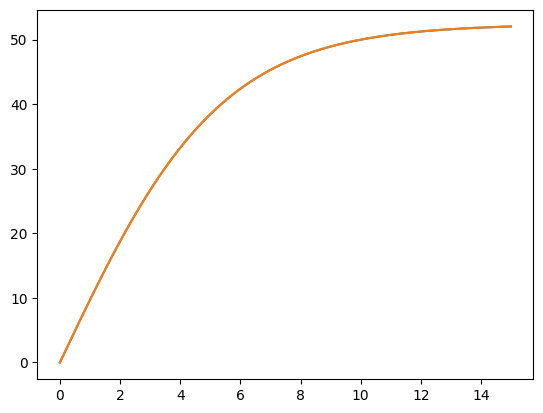

In [114]:
plt.plot(ts, v_exact);
plt.plot(ts, v_naive);

## Runge-Kutta method

Runge-Kutta uses the idea outlined above, but it takes 2 intermediate, averaging steps:

In the $n^\text{th}$ step, $y_{n+1}$ is computed as
$$ y_{n+1} = y_n+\frac{h}{6}(k_1+2k_2+2k_3+k_4)$$ where 
$$ \begin{align}
k_1 &= F(x_n, y_n) \\ 
k_2 &= F(x_n + h/2, y_n + h/2 k_1) \\
k_3 &= F(x_n + h/2, y_n + h/2 k_2) \\
k_4 &= F(x_n + h, y_n + h k_3)
\end{align}
$$

This is a fourth order method (meaning the error in each step is $O(h^5)$, such that the total accumulated error is $O(h^4)$. For this reason, this method is often called RK4.

In [4]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [5]:
def rk4(f, x_n, y_n, h=1e-2):
    k_1 = f(x_n, y_n)
    k_2 = f(x_n + h/2, y_n + h/2 * k_1)
    k_3 = f(x_n + h/2, y_n + h/2 * k_2)
    k_4 = f(x_n + h, y_n + h * k_3)
    return y_n + h / 6 * (k_1 + 2 * k_2 + 2 * k_3 + k_4)

In [6]:
b, g, m = .25, 9.81, 70
v_T, t_star = jnp.sqrt(m * g / b), jnp.sqrt(m / (g * b))
h = 1e-2
ts_exact = jnp.arange(0, 15, h)

# exact result
v_exact = v_T * jnp.tanh(ts_exact / t_star)

# Runge Kutta 4
def f(t, v):
    return b / m * (v_T**2 - v**2)

h = 3.
ts = jnp.arange(0, 15, h)
v_rk = [0]    
for t, v in zip(ts, v_rk):
    v_rk.append(rk4(f, t, v, h))
v_rk = v_rk[:-1]

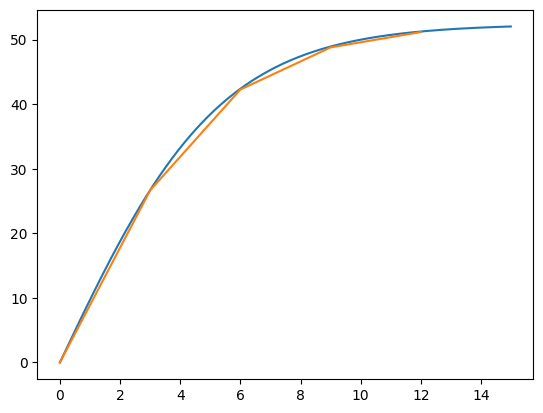

In [186]:
plt.plot(ts_exact, v_exact);
plt.plot(ts, v_rk);

## More on Runge-Kutta

### Implict Methods

The above warmup and RK example was a so-called explicit method, since we computed $y_{n+1}$ using only $y_n$. To be more concrete, in our warmup example we used
$$y_{n+1} = y_n + h F(x_n,y_n)$$
Instead, we could have used $y_{n+1}$ in $F(x,y)$:
$$y_{n+1} = y_n + h F(x_{n+1},y_{n+1})$$
This leads to implicit methods. Implicit, since both the LHS and RHS depend on $y_{n+1}$. Depending on the ODE (more precisely on $F$), we might not even be able to solve the resulting equation for $y_{n+1}$ explicitly analytically. In such a case, we need a numeric method (e.g., Newton's method introduced in week 1) to solve for $y_{n+1}$. It might nevertheless be worthwhile to do this, in particular for so-called stiff ODEs (these are ODEs for which explicit methods are numerically unstable unless $h$ is taken to be very small, since they fluctuate strongly).

#### Example of a stiff equation
As an example, let us consider the ODE
$$y'(x)=-15y(x)\,,\qquad y(0)=1\,.$$
This has the exact solution $y(x)=e^{-15x}$. Let us illustrate what happens if we usethe explicit vs implicit formula above. In that case, $F(x,y)=-15y$. 

For the explicit case, we get
$$y_{n+1} = y_n - h F(x_n,y_n)=y_n + h (-15 y_n)=y_n(1-15h)$$
For the implicit case, we get
$$y_{n+1} = y_n - h F(x_{n+1},y_{n+1})=y_n + h (-15 y_{n+1}) \quad\Rightarrow\quad y_{n+1} = \frac{y_n}{1+15h}$$


In [131]:
b, g, m = .25, 9.81, 70
v_T, t_star = jnp.sqrt(m * g / b), jnp.sqrt(m / (g * b))
h = .25
ts = jnp.arange(0, 1, h)

# exact result
v_exact = jnp.exp(-15 * ts)

v_explicit = [1]    
for t, v in zip(ts, v_explicit):
    v_explicit.append(v_explicit[-1] * (1 - 15*h))
v_explicit = v_explicit[:-1]

v_implicit = [1]    
for t, v in zip(ts, v_implicit):
    v_implicit.append(v_implicit[-1] / (1 + 15*h))
v_implicit = v_implicit[:-1]

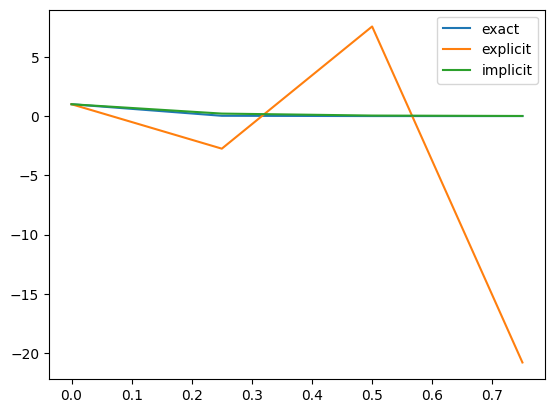

In [132]:
plt.plot(ts, v_exact, label="exact");
plt.plot(ts, v_explicit, label="explicit");
plt.plot(ts, v_implicit, label="implicit");
plt.legend();

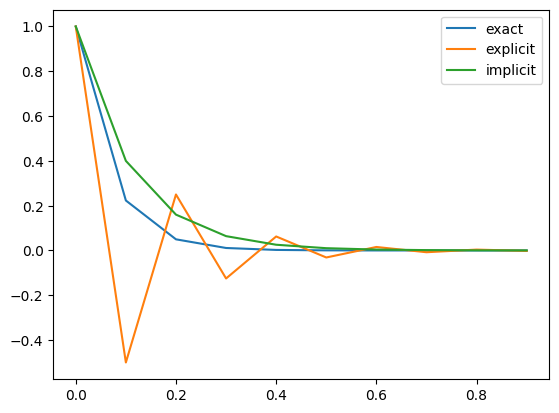

In [133]:
# The exact result improves with smaller step size
h = .1
ts = jnp.arange(0, 1, h)

# exact result
v_exact = jnp.exp(-15 * ts)

v_explicit = [1]    
for t, v in zip(ts, v_explicit):
    v_explicit.append(v_explicit[-1] * (1 - 15*h))
v_explicit = v_explicit[:-1]

v_implicit = [1]    
for t, v in zip(ts, v_implicit):
    v_implicit.append(v_implicit[-1] / (1 + 15*h))
v_implicit = v_implicit[:-1]

plt.plot(ts, v_exact, label="exact");
plt.plot(ts, v_explicit, label="explicit");
plt.plot(ts, v_implicit, label="implicit");
plt.legend();

### Generalized RK

In the RK4 method discussed above, we used 4 $k_i$ eveluated at one intermediate point (at $x_n+h/2$). One can generalize this to using $s$ stages (meaning $s$ different $k_i$ at some intermediate positions $x_n+c_i h$) and weigh them with some numbers $b_i$:
$$y_{n+1}=y_n+h\sum_{i=1}^{s}b_i k_i$$
where 
$$\begin{align}
k_1&=f(x_n,y_n)\\
k_2&=f(x_n+c_2 h, y_n + (a_{21} k_1)h)\\
k_3&=f(x_n+c_2 h, y_n + (a_{31} k_1 + a_{32} k_2)h)\\
&\vdots\\
k_s&=f(x_n+c_s h, y_n + (a_{s,1} k_1 + a_{s,2} k_2 + a_{s,s-1})h)\\
\end{align}$$
One typically summarizes the coefficients in a so-called Butcher tableau (after John Butcher):
<table>
<tr><td style="border-right: thin solid black;">0</td><td></td></tr>
<tr><td style="border-right: thin solid black;">$c_2$</td><td>$a_{21}$</td></tr>
<tr><td style="border-right: thin solid black;">$c_3$</td><td>$a_{31}$</td><td>$a_{32}$</td></tr>
<tr><td style="border-right: thin solid black;">$\vdots$</td><td>$\vdots$</td><td>$\vdots$</td><td>$\ddots$</td></tr>
<tr style="border-bottom: thin solid black;"><td style="border-right: thin solid black;">$c_s$</td><td>$a_{s1}$</td><td>$a_{s2}$</td><td>$\cdots$</td><td>$a_{s,s-1}$</td><td>&nbsp;</td></tr>
<tr><td style="border-right: thin solid black;"> </td><td>$b_1$</td><td>$b_2$</td><td>$\cdots$</td><td>$b_{s-1}$</td><td>$b_{s}$</td></tr>    
</table>
Note:

- The fact that this is lower-diagonal means that we can compute $k_{j+1}$ from $k_{1},k_{2},\ldots,k_j$, but we do not involve $k_{j+1},k_{j+2},\ldots,k_{s}$. This means it is an explicit method; a generalization to implicit RK methods is also possible, in which case the Butcher tableau becomes a full $s\times s$ matrix.
- One can show (using Tayler series expansions) that a RK method is consistent if and only if $\sum_{i=1}^{s}b_i=1$. However, just choosing the coefficients randomly does not mean that the RK method is also efficient (meaning it is of a high order in $h$).

As an example, our RK4 method fits into this framework with Butcher Tableau
<table>
<tr><td style="border-right: thin solid black;">0</td><td></td></tr>
<tr><td style="border-right: thin solid black;">$1/2$</td><td>$1/2$</td></tr>
<tr><td style="border-right: thin solid black;">$1/2$</td><td>$0$</td><td>$1/2$</td></tr>
<tr style="border-bottom: thin solid black;"><td style="border-right: thin solid black;">$1$</td><td>$0$</td><td>$0$</td><td>$1$</td><td></td></tr>
<tr><td style="border-right: thin solid black;"> </td><td>$1/6$</td><td>$1/3$</td><td>$1/3$</td><td>$1/6$</td></tr>    
</table>

#### Example: Generalized RK

In [204]:
import random

def generalized_rk(f, x_n, y_n, aijs, bs, cs, h=1e-2):
    ks = [f(x_n, y_n)]
    for aij, c in zip(aijs, cs):
        ks.append(f(x_n + c * h, y_n + h * jnp.sum(jnp.array([a * k for a, k in zip(aij, ks)]))))
    return y_n + h * jnp.sum(jnp.array(ks) * jnp.array(bs))
# RK4
as_rk4 = [[1/2], [0, 1/2], [0, 0, 1]]
bs_rk4 = [1/6, 1/3, 1/3, 1/6]
cs_rk4 = [1/2, 1/2, 1]

# random consistent RK
as_rc = [[random.random() for _ in range(i)] for i in range(1, 4)]
bs_rc = [random.random() for _ in range(3)]
bs_rc += [1 - sum(bs_rc)] 
cs_rc = [random.random() for _ in range(3)]

# random inconsistent RK
as_ric = [[random.random() for _ in range(i)] for i in range(1, 4)]
bs_ric = [2 * random.random() for _ in range(4)]
cs_ric = [random.random() for _ in range(3)]



b, g, m = .25, 9.81, 70
v_T, t_star = jnp.sqrt(m * g / b), jnp.sqrt(m / (g * b))
h = 1e-2
ts_exact = jnp.arange(0, 15, h)
def f(t, v):
    return b / m * (v_T**2 - v**2)

# exact result
v_exact = v_T * jnp.tanh(ts_exact / t_star)

h = 2
ts = jnp.arange(0, 15, h)

v_rk4 = [0]    
for t, v in zip(ts, v_rk4):
    v_rk4.append(generalized_rk(f, t, v, as_rk4, bs_rk4, cs_rk4, h))
v_rk4 = v_rk4[:-1]

v_rc = [0]    
for t, v in zip(ts, v_rc):
    v_rc.append(generalized_rk(f, t, v, as_rc, bs_rc, cs_rc, h))
v_rc = v_rc[:-1]

v_ric = [0]    
for t, v in zip(ts, v_ric):
    v_ric.append(generalized_rk(f, t, v, as_ric, bs_ric, cs_ric, h))
v_ric = v_ric[:-1]

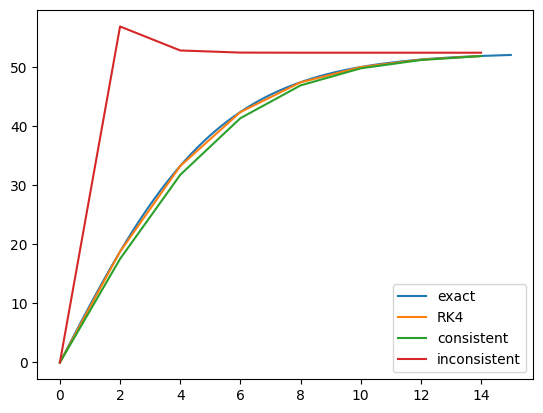

In [205]:
plt.plot(ts_exact, v_exact, label="exact");
plt.plot(ts, v_rk4, label="RK4");
plt.plot(ts, v_rc, label="consistent");
plt.plot(ts, v_ric,  label="inconsistent");
plt.legend();

### Adaptive RK

If a function changes a lot, small step sizes need to be taken, whereas steps can be very big if the function is almost constant. To account for this, we can use an estimate for the error and adapt the step size dynamically following this algorithm:

1. The user inputs a threshold
2. 
a. If the estimated error is above the threshold, the step is repeated with a smaller step size
b. If the estimated error is (much) below the threshold, the step is carried out, but the step size is increased for the next iteration

To estimate the error, we want to reuse as much data as possible to avoid costly computations being carried out twice. The idea is to use two methods with the same same $a$ and $c$ in the tableau (computinmg the $k$s is the most expensive step) but different $b$ values. The $b$ are chosen such that one choice (call them $b^{(p)}$) gives an order $p$ method and the other ($b^{(p-1)}$) gives an order $p-1$ method. The error in the $(n+1)^\text{st}$ step is then estimated as
$$\epsilon_{n+1}=|y_{n+1}^{p} - y_{n+1}^{p-1}|=h|\sum_{i=1}^s (b^{p}-b^{(p-1)}) k_i|\,.$$

As an example we can use backward diff (which is order 1), and RK2 (which is order 2) with a tableau
<table>
<tr><td style="border-right: thin solid black;">0</td><td></td></tr>
<tr style="border-bottom: thin solid black;"><td style="border-right: thin solid black;">$1$</td><td>$1$</td><td></td></tr>
<tr><td style="border-right: thin solid black;">$b^{(2)}$</td><td>$1/2$</td><td>$1/2$</td></tr>
<tr><td style="border-right: thin solid black;">$b^{(1)}$</td><td>$1$</td><td>$0$</td></tr>    
</table>


In [17]:
def rk21(f, x_n, y_n, h, tol=1e-1):
    k_1 = f(x_n, y_n)
    k_2 = f(x_n + h, y_n + h * k_1)
    err = 0
    while True:
        k_1 = f(x_n, y_n)
        k_2 = f(x_n + h, y_n + h * k_1)
        y_p = y_n + h / 2 * (k_1 + k_2)
        y_pm1 = y_n + h * k_1
        err = jnp.abs(y_p - y_pm1)
        if err > tol:
            print("Error {:.4f} above tolerance {:.4f} for x_n={:.4f}. Cutting step size from {:.4f} to {:.4f}.".format(err, tol, x_n, h, h/1.5))
            h /= 1.5
            if h < 1e-6:
                print("Tolerance {} cannot be achieved with this method.".format(tol))
        elif err < .1 * tol:
            print("Error {:.4f} far below tolerance {:.4f} for x_n={:.4f}. Increasing step size from {:.4f} to {:.4f}.".format(err, tol, x_n, h, 1.5 * h))
            h *= 1.5
            break
        else:
            break
    return h, y_p

In [20]:
h = 1
x_n = [0.]
v_rk21 = [0.]
while x_n[-1] < 15:
    h, y_n = rk21(f, x_n[-1], v_rk21[-1], h, tol=.01)
    x_n.append(x_n[-1] + h)
    v_rk21.append(y_n)
print("Performed {:d} steps".format(len(x_n) - 1))

Error 0.1719 above tolerance 0.0100 for x_n=0.0000. Cutting step size from 1.0000 to 0.6667.
Error 0.0509 above tolerance 0.0100 for x_n=0.0000. Cutting step size from 0.6667 to 0.4444.
Error 0.0151 above tolerance 0.0100 for x_n=0.0000. Cutting step size from 0.4444 to 0.2963.
Error 0.0133 above tolerance 0.0100 for x_n=0.2963. Cutting step size from 0.2963 to 0.1975.
Error 0.0103 above tolerance 0.0100 for x_n=0.6914. Cutting step size from 0.1975 to 0.1317.
Error 0.0103 above tolerance 0.0100 for x_n=2.0082. Cutting step size from 0.1317 to 0.0878.
Error 0.0010 far below tolerance 0.0100 for x_n=10.6118. Increasing step size from 0.0878 to 0.1317.
Error 0.0010 far below tolerance 0.0100 for x_n=12.9822. Increasing step size from 0.1317 to 0.1975.
Performed 140 steps


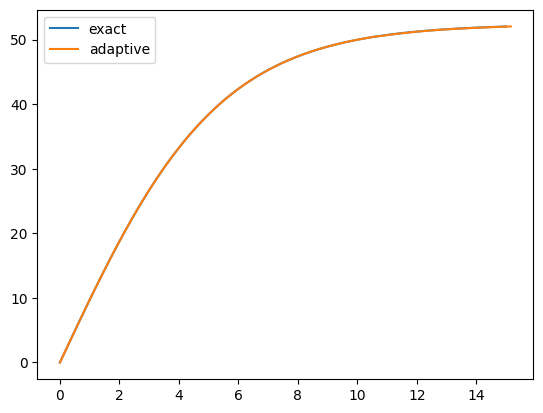

In [21]:
plt.plot(ts_exact, v_exact, label="exact");
plt.plot(x_n, v_rk21, label="adaptive");
plt.legend();

## Neural Network

We want to find an unknown function $y(x)$ such that
$$ \frac{dy(x)}{dx} = F(x,y(x))$$
Since NN can in theory learn any function, we can simply approximate $y(x)$ by a NN. Since we do not have labels (i.e., pairs (x, y(x))), thius is not a classical supervised learning task. Instead, we can use the ODE itself as a loss function (this requires taking derivatives of the NN with respect to its input parameter $x$):
$$\mathcal{L} = |y'(x) - F(x,y(x))| + |y(0) - y_0|$$
Note:
- The first term enforces the ODE and the second term enforces the boundary condition. If we find that the NN learns one much more accurately than the other, we can include weight factors $\mu_1$ and $\mu_2$ and write $\mathcal{L} = \mu_1|y'(x) - F(x,y(x))| + \mu_2|y(0) - y_0|$. By dialing the relative value of $\mu_1$ and $\mu_2$, we can put more emphasis on the first or the second term
- Instead of the absolute value, we could also have used square or some other norm
- We could also have written $|y'/F(x,y(x))-1|$ or similar for the first term provided F(x,y(x)) is not zero. In fact, writing it like this might hel preventing it from becoming zero during training.
- For ODEs, getting the data (the $x$ values) is often almost free; you sample them randomly (or evenly spaced) from some interval. This means we could use new points in each epoch, which typically improves training.

In [97]:
from jax import grad, jit, vmap
key = jax.random.PRNGKey(12)

# Neural network architecture
def init_network_params(key):
    sizes = [1, 32, 32, 1]  # Number of nodes in each layer
    keys = jax.random.split(key, len(sizes) - 1)
    params = [(1/jnp.sqrt(n) * jax.random.normal(k, (m, n)), 1/n * jax.random.normal(k, (n,))) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]
    return params

@jit
def neural_network(params, x):
    for i, (w, b) in enumerate(params):
        x = jnp.dot(x, w) + b
        if i != len(params) - 1:
            x = jax.nn.sigmoid(x)
    return x

@jit
def loss(params, x):
    y = neural_network(params, x)
    y_0 = neural_network(params, jnp.array([0.]))[0]

    # this code is essentially reshaping the output of NN to be a number instead of an array containg a number
    # then it is parallelizing the gradient computation over all input points
    grad_v = jax.vmap(jax.grad(lambda p, t: neural_network(p, t)[0], argnums=1), (None, 0))
    y_prime = grad_v(params, ts)  # argnums=1 means we take the derivative w.r.t. x
    y_prime = jnp.ravel(y_prime)
    
    f_eval = f(x, y)
    return jnp.mean((y_prime - f_eval)**2) + jnp.abs(y_0 - 0.)

# Training loop
def train(params, ts, learning_rate=1e-2, epochs=list(range(101))):
    _, subkey = jax.random.split(key)
    ts_test = 15 * jax.random.uniform(subkey, shape=(1000, 1))
    for epoch in epochs:
        train_loss, test_loss = loss(params, ts), loss(params, ts_test)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        gradients = grad(loss)(params, ts)
        params = [(w - learning_rate * dw, b - learning_rate * db) for (w, b), (dw, db) in zip(params, gradients)]
        if epoch % 100 == 0:
            print("Epoch {:3d}, Train Loss: {:.4f}, Test Loss: {:.4f}".format(epoch, train_loss, test_loss))
            print("Gradient avg:", jnp.sum(jnp.array([jnp.sum(jnp.abs(x0)) + jnp.sum(jnp.abs(x1)) for (x0, x1) in gradients])))
    return params

# Initialize network parameters
params = init_network_params(key)
print("Summary of NN:")
total_num = 0
for i in range(len(params)):
    total_num += params[i][0].shape[0] * params[i][0].shape[1] + params[i][1].shape[0]
    print("Layer {}: Weights: {}, Biases: {}, Total: {} parameters".format(i + 1, 
                                                                     params[i][0].shape, 
                                                                     params[i][1].shape, 
                                                                     params[i][0].shape[0] * params[i][0].shape[1] + params[i][1].shape[0])
         )
print("The NN has {} parameters.\n\n".format(total_num))

# Train the neural network
print("Training the NN...")
epochs, train_losses, test_losses = list(range(5001)), [], []
ts = jnp.reshape(ts, (len(ts), 1))
params = train(params, ts, learning_rate=1e-3, epochs=epochs)

Summary of NN:
Layer 1: Weights: (1, 32), Biases: (32,), Total: 64 parameters
Layer 2: Weights: (32, 32), Biases: (32,), Total: 1056 parameters
Layer 3: Weights: (32, 1), Biases: (1,), Total: 33 parameters
The NN has 1153 parameters.


Training the NN...
Epoch   0, Train Loss: 96.9996, Test Loss: 96.9998
Gradient avg: 111.28924
Epoch 100, Train Loss: 95.1217, Test Loss: 95.1220
Gradient avg: 121.853645
Epoch 200, Train Loss: 93.3775, Test Loss: 93.3795
Gradient avg: 139.53702
Epoch 300, Train Loss: 91.3964, Test Loss: 91.4018
Gradient avg: 145.96492
Epoch 400, Train Loss: 89.1258, Test Loss: 89.1364
Gradient avg: 155.9497
Epoch 500, Train Loss: 86.5499, Test Loss: 86.5675
Gradient avg: 150.84715
Epoch 600, Train Loss: 83.6173, Test Loss: 83.6432
Gradient avg: 158.17772
Epoch 700, Train Loss: 80.2570, Test Loss: 80.2924
Gradient avg: 165.4098
Epoch 800, Train Loss: 76.3171, Test Loss: 76.3630
Gradient avg: 172.01378
Epoch 900, Train Loss: 71.6827, Test Loss: 71.7402
Gradient avg: 179.38

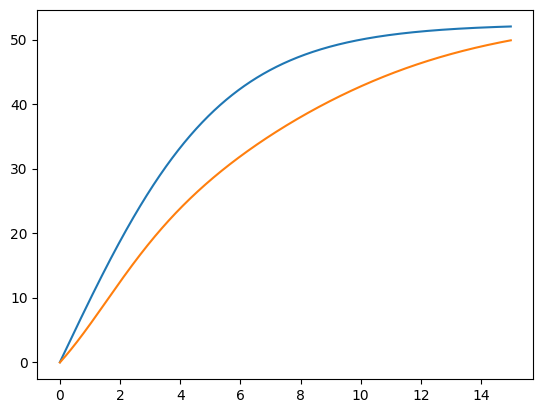

In [98]:
v_exact = v_T * jnp.tanh(ts / t_star)
v_nn = jnp.ravel(neural_network(params, ts))
plt.plot(ts, v_exact);
plt.plot(ts, v_nn);